# Vision Language Model Evaluation

This notebook evaluates multiple vision language models (e.g., LLaVA-NeXT, GPT-5o and Qwen3-VL) on three systematically constructed image datasets designed to probe color-concept representations: canonical object colors, counterfactual recolorings and abstract colored shapes.


In [28]:
%reload_ext autoreload
%autoreload 2

from transformers import (
    BitsAndBytesConfig,
    LlavaNextProcessor,
    LlavaNextForConditionalGeneration,
    AutoProcessor,
    AutoModelForVision2Seq
)
import torch
import pandas as pd
import gc
import numpy as np
from tqdm import tqdm
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt

ROOT = Path().resolve().parents[0]
sys.path.insert(0, str(ROOT))

from test_MLLMs import run_vlm_evaluation, ask_vlm_introspection_threshold
from making_color_images.plot_variants import plot_vlm_prolific

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

fontsize = 14

In [3]:
# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
DATA = WORK / "color-concept-entanglement" / "data"

FRUIT = DATA / "fruit"
OUTLINES = DATA / "color_images"

RESIZED_IMGS = DATA / "resized_images"
RESIZED_MASKS = DATA / "resized_cv_masks"
RESIZED_IMGS.mkdir(parents=True, exist_ok=True)
RESIZED_MASKS.mkdir(parents=True, exist_ok=True)

In [4]:
# Set a specific seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True
)

torch.cuda.empty_cache()
gc.collect()

Using device: cuda


498

In [5]:
# Load the datasets that where also used in the human evaluation
prior_df = pd.read_csv(DATA / "prolific_stimuli" / f"stimulus_table_image_priors_prolific.csv")
counterfact_df = pd.read_csv(DATA / "prolific_stimuli" / f"stimulus_table_counterfact_prolific.csv")
shape_df = pd.read_csv(DATA / "prolific_stimuli" / f"stimulus_table_shapes_prolific.csv")

def norm_image_paths(df):
    df = df.copy()
    df["image_path"] = df["image_path"].apply(
    lambda p: str(DATA / p)
    )
    return df

prior_df = norm_image_paths(prior_df)
counterfact_df = norm_image_paths(counterfact_df)
shape_df = norm_image_paths(shape_df)

display(prior_df.head(), prior_df.shape, counterfact_df.head(), counterfact_df.shape, shape_df.head(), shape_df.shape)

,image_path,object,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,correct_prior,brown,brown,FG,100,FG 100% (seq),seq


(1260, 9)

,image_path,object,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,counterfact,red,red,FG,20,FG 20% (seq),seq


(412, 9)

,image_path,object,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,shape,orange,orange,FG,90,FG 90% (seq),seq


(1331, 9)

In [7]:
def evaluate_vlm_on_stimuli(
    df_stimuli: pd.DataFrame,
    *,
    processor=None,
    model=None,
    device,
    image_root: Path,
    backend: str = "llava",      # "llava" | "gpt" | "qwen"
    model_name: str | None = None,
    batch_size: int = 1,
    mode: str = "this",
    desc: str = "Evaluating stimuli",
):
    """
    Evaluate a VLM on a set of stimulus images.

    Expects df_stimuli to have columns:
      - image_path (relative to image_root)
      - object
      - target_color
    """

    preds = []

    for _, row in tqdm(
        df_stimuli.iterrows(),
        total=len(df_stimuli),
        desc=desc,
    ):

        df_eval_input = pd.DataFrame({
            "image_path": [image_root / row["image_path"]],
            "object": [row["object"]],
            "correct_answer": [row["target_color"]],
        })

        df_eval = run_vlm_evaluation(
            df=df_eval_input,
            processor=processor,
            model=model,
            device=device,
            batch_size=batch_size,
            mode=mode,
            return_probs=True,
            backend=backend,
            model_name=model_name,
        )

        cols = [
            "object",
            "image_path",
            "correct_answer",
            "pred_color_this",
        ]

        # Only include probabilities if they exist (torch backends)
        if "prob_correct_this" in df_eval.columns:
            cols.append("prob_correct_this")

        preds.append(df_eval[cols])

        if backend in ["llava", "qwen"]:
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            gc.collect()

    return pd.concat(preds, ignore_index=True)

# 1. LLaVA-NeXT

In [29]:
model_name = "llava-v1.6-mistral-7b-hf"
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf", dtype=torch.float16, low_cpu_mem_usage=True, device_map="auto", quantization_config=bnb_config
).to(device)

LLAVA = DATA / "LLaVA-NeXT_results"
LLAVA.mkdir(parents=True, exist_ok=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 1.1. Introspection question (LLaVA-NeXT)

In [31]:
calibration = ask_vlm_introspection_threshold(
    backend="llava",
    processor=processor,
    model=model,
    device=device,
    model_name=model_name,
)

threshold = calibration["introspection_threshold"]
print(threshold)

for any object, x% of its pixels should be colored for it to be considered that color. 
                        for example, imagine an image of a banana, where only part of the banana in the image is colored yellow.
                        at what point would you personally say that the banana in the image is yellow?
                        what value should x% be? please answer with a single number between 0 and 100.


## 1.2. Color Prior Dataset (LLaVA-NeXT)

In [ ]:
suffix = "image_priors"
llava_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    processor=processor,
    model=model,
    device=device,
    image_root=DATA,
    desc="Evaluating canonical object colors (correct-prior stimuli)",
)

out_path = LLAVA / f"evaluation_{model_name}_{suffix}.csv"
llava_prior_pred_df.to_csv(out_path, index=False)


Evaluating canonical object colors (correct-prior stimuli): 100%|██████████| 1260/1260 [48:00<00:00,  2.29s/it]


,object,image_path,correct_answer,pred_color_this,prob_correct_this,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,cheese,/mnt/lustre/work/eickhoff/esx061/color-concept...,yellow,white,0.312744,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,espresso maker,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,red,0.433594,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,tile roof,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,red,0.950195,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,cloud,/mnt/lustre/work/eickhoff/esx061/color-concept...,grey,grey,0.004078,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,frilled lizard,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,0.649902,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...
1255,eggplant,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,0.765137,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,rattlesnake,/mnt/lustre/work/eickhoff/esx061/color-concept...,white,black and white,0.339355,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,tow truck,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,0.729980,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,snake,/mnt/lustre/work/eickhoff/esx061/color-concept...,green,green,0.881348,correct_prior,green,green,FG,50,FG 50% (seq),seq


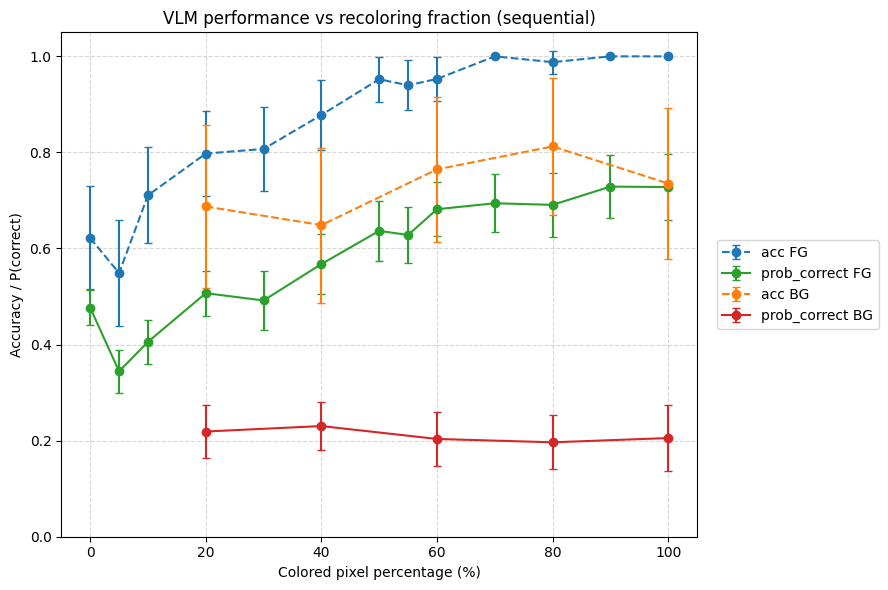

In [32]:
llava_prior_pred_df = pd.read_csv(LLAVA / "evaluation_llava-v1.6-mistral-7b-hf_image_priors.csv")
llava_prior_pred_df = llava_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(llava_prior_pred_df)
plot_vlm_prolific(llava_prior_pred_df, ci=True)

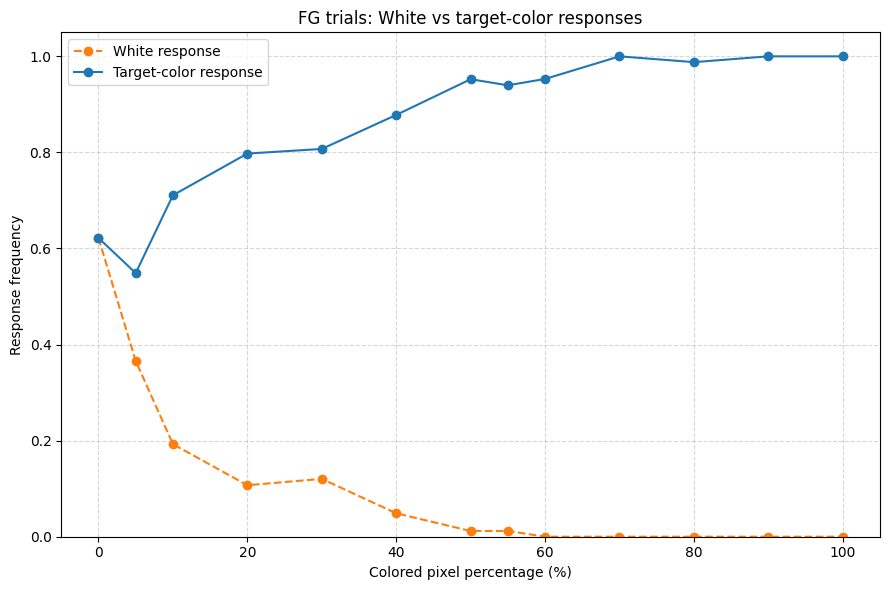

In [34]:
df_fg = llava_prior_pred_df[llava_prior_pred_df["variant_region"] == "FG"].copy()

df_fg["is_white"] = df_fg["pred_color_this"] == "white"
df_fg["is_target"] = df_fg["pred_color_this"] == df_fg["target_color"]

fg_summary = (
    df_fg
    .groupby("percent_colored")
    .agg(
        p_white=("is_white", "mean"),
        p_target=("is_target", "mean"),
        n=("is_white", "count")
    )
    .reset_index()
)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    fg_summary["percent_colored"],
    fg_summary["p_white"],
    "o--",
    label="White response",
    color="#ff7f0e",
)

ax.plot(
    fg_summary["percent_colored"],
    fg_summary["p_target"],
    "o-",
    label="Target-color response",
    color="#1f77b4",
)

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("FG trials: White vs target-color responses")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

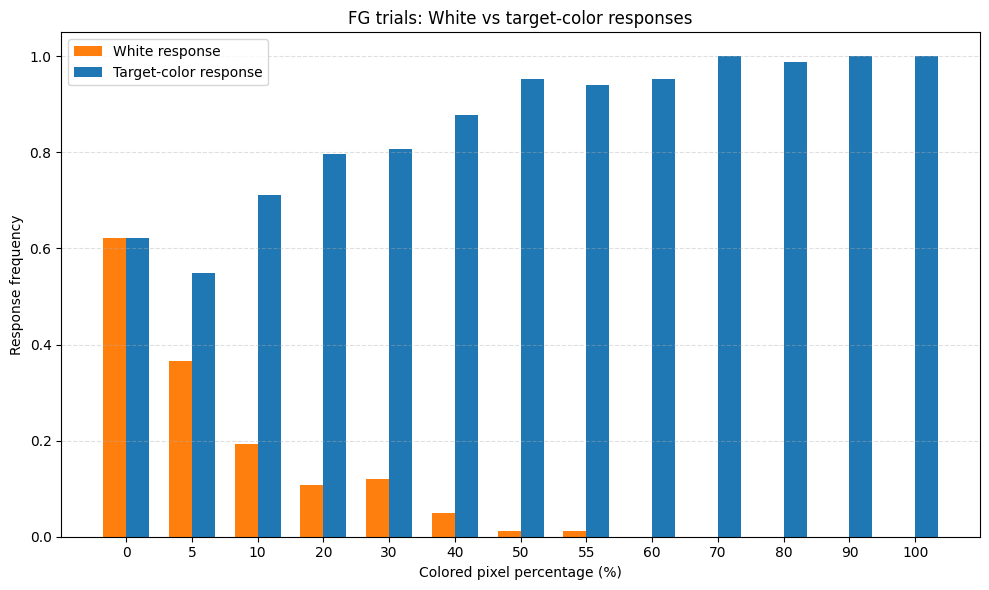

In [36]:
x = np.arange(len(fg_summary))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x - width / 2,
    fg_summary["p_white"],
    width,
    label="White response",
    color="#ff7f0e",
)

ax.bar(
    x + width / 2,
    fg_summary["p_target"],
    width,
    label="Target-color response",
    color="#1f77b4",
)

ax.set_xticks(x)
ax.set_xticklabels(fg_summary["percent_colored"])
ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("FG trials: White vs target-color responses")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

In [ ]:
df_bg = df_complete[df_complete["variant_region"] == "BG"].copy()

df_bg["is_white"] = df_bg["response_label"] == "white"
df_bg["is_colored"] = ~df_bg["is_white"]

bg_summary = (
    df_bg
    .groupby("percent_colored")
    .agg(
        p_white=("is_white", "mean"),
        p_colored=("is_colored", "mean"),
        n=("is_white", "count")
    )
    .reset_index()
)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    bg_summary["percent_colored"],
    bg_summary["p_white"],
    "o-",
    label="White response (correct)",
    color="#2ca02c",
)

ax.plot(
    bg_summary["percent_colored"],
    bg_summary["p_colored"],
    "o--",
    label="Any color response (error)",
    color="#d62728",
)

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("BG trials: White vs color-attribution errors")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

## 1.3. Counterfact Color Dataset (LLaVA-NeXT)

In [ ]:
suffix = "counterfact"
llava_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    processor=processor,
    model=model,
    device=device,
    image_root=DATA,
    desc="Evaluating counterfact object colors (counterfact stimuli)",
)

out_path = LLAVA / f"evaluation_{model_name}_{suffix}.csv"
llava_cf_pred_df.to_csv(out_path, index=False)

Evaluating counterfact object colors (counterfact stimuli): 100%|██████████| 412/412 [15:24<00:00,  2.24s/it]


,object,image_path,correct_answer,pred_color_this,prob_correct_this,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,rose,/mnt/lustre/work/eickhoff/esx061/color-concept...,blue,blue,0.974609,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,sealyham terrier,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,0.908203,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,iguana,/mnt/lustre/work/eickhoff/esx061/color-concept...,orange,orange,0.720703,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,hartebeest,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,red,0.602539,counterfact,red,red,FG,55,FG 55% (seq),seq
4,mouse,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,white,0.327148,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...
407,trailer truck,/mnt/lustre/work/eickhoff/esx061/color-concept...,orange,orange,0.857422,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,frilled lizard,/mnt/lustre/work/eickhoff/esx061/color-concept...,pink,pink,0.475098,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,coho,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,0.535156,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,butternut squash,/mnt/lustre/work/eickhoff/esx061/color-concept...,green,green,0.849609,counterfact,green,green,FG,70,FG 70% (seq),seq


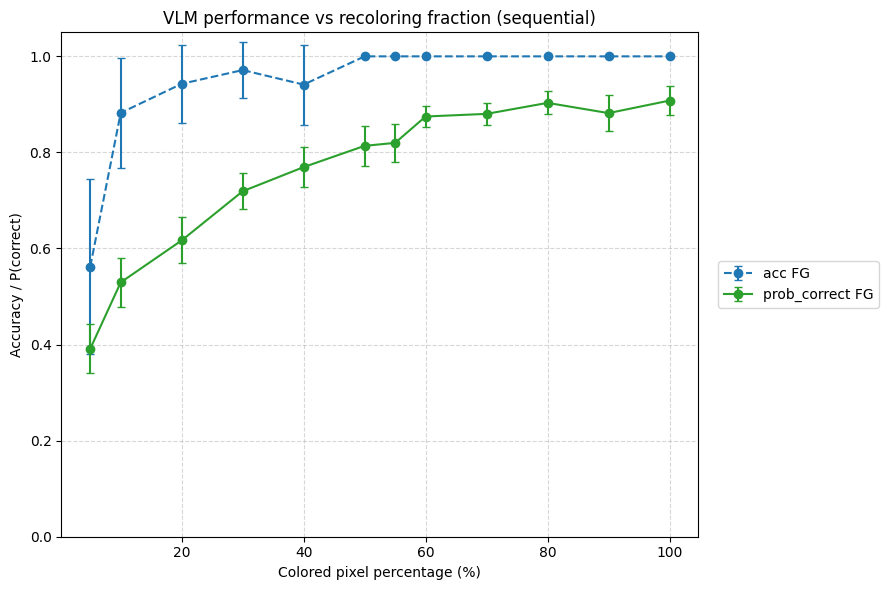

In [102]:
llava_cf_pred_df = pd.read_csv(LLAVA / "evaluation_llava-v1.6-mistral-7b-hf_counterfact.csv")
llava_cf_pred_df = llava_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(llava_cf_pred_df)
plot_vlm_prolific(llava_cf_pred_df, ci=True)

## 1.4. Shape Dataset (LLaVA-NeXT)

In [ ]:
suffix = "shapes"
llava_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    processor=processor,
    model=model,
    device=device,
    image_root=DATA,
    desc="Evaluating shapes",
)

out_path = LLAVA / f"evaluation_{model_name}_{suffix}.csv"
llava_shape_pred_df.to_csv(out_path, index=False)

,object,image_path,correct_answer,pred_color_this,prob_correct_this,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,hexagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,yellow,yellow,0.847656,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,pentagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,0.885254,shape,purple,purple,FG,55,FG 55% (seq),seq
2,square,/mnt/lustre/work/eickhoff/esx061/color-concept...,blue,blue,0.454346,shape,blue,blue,FG,5,FG 5% (seq),seq
3,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,0.634277,shape,brown,brown,FG,50,FG 50% (seq),seq
4,pentagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,orange,orange,0.816895,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...
1326,circle,/mnt/lustre/work/eickhoff/esx061/color-concept...,grey,grey,0.003328,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,hexagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,0.655762,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,white,black,0.286865,shape,blue,white,FG,0,FG 0% (seq),seq
1329,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,white,0.108643,shape,red,white,BG,40,BG 40% (seq),seq


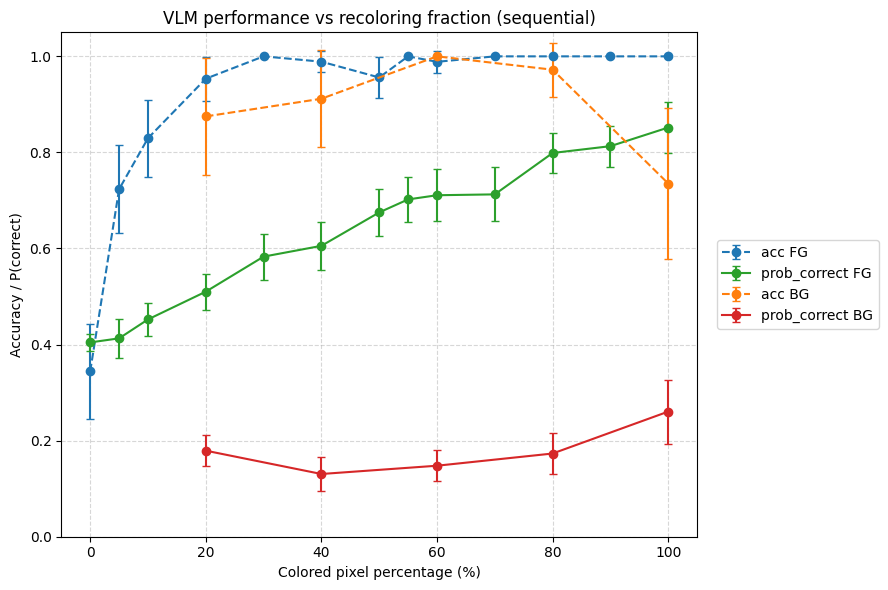

In [104]:
llava_shape_pred_df = pd.read_csv(LLAVA / "evaluation_llava-v1.6-mistral-7b-hf_shapes.csv")
llava_shape_pred_df = llava_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(llava_shape_pred_df)
plot_vlm_prolific(llava_shape_pred_df, ci=True)

# 2. GPT-5o

In [ ]:
model_name = "gpt-4o"
GPT = DATA / "GPT_results"
GPT.mkdir(parents=True, exist_ok=True)

## 2.1. Introspection question (GPT-4o)

In [22]:
calibration = ask_vlm_introspection_threshold(
    backend="gpt",
    model_name=model_name,
)

threshold = calibration["introspection_threshold"]
print(threshold)

50


## 2.2. Color Prior Dataset (GPT-4o)

In [21]:
suffix = "image_priors"
gpt_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    backend="gpt",
    model_name="gpt-4o",
    image_root=DATA,
    device=None,   # ignored for GPT
)

out_path = GPT / f"evaluation_{model_name}_{suffix}.csv"
gpt_prior_pred_df.to_csv(out_path, index=False)

Evaluating stimuli:   0%|          | 0/1260 [00:00<?, ?it/s]


KeyboardInterrupt: 

,object,image_path,correct_answer,pred_color_this,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,cheese,/mnt/lustre/work/eickhoff/esx061/color-concept...,yellow,yellow,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,espresso maker,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,black,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,tile roof,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,red,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,cloud,/mnt/lustre/work/eickhoff/esx061/color-concept...,grey,grey,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,frilled lizard,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...
1255,eggplant,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,rattlesnake,/mnt/lustre/work/eickhoff/esx061/color-concept...,white,black,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,tow truck,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,snake,/mnt/lustre/work/eickhoff/esx061/color-concept...,green,green,correct_prior,green,green,FG,50,FG 50% (seq),seq


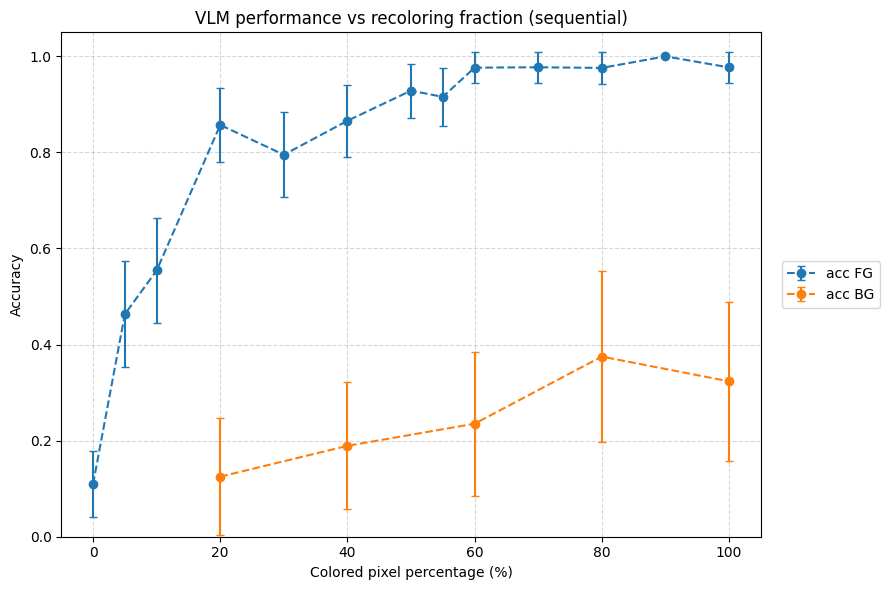

In [105]:
gpt_prior_pred_df = pd.read_csv(GPT / "evaluation_gpt-4o_image_priors.csv")
gpt_prior_pred_df = gpt_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(gpt_prior_pred_df)
plot_vlm_prolific(gpt_prior_pred_df, ci=True)

## 2.3. Counterfact Color Dataset (GPT-4o)

In [26]:
suffix = "counterfact"
gpt_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    backend="gpt",
    model_name="gpt-4o",
    image_root=DATA,
    device=None,   # ignored for GPT
)

out_path = GPT / f"evaluation_shapes_{model_name}_{suffix}.csv"
gpt_cf_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 412/412 [06:40<00:00,  1.03it/s]


,object,image_path,correct_answer,pred_color_this,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,rose,/mnt/lustre/work/eickhoff/esx061/color-concept...,blue,blue,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,sealyham terrier,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,iguana,/mnt/lustre/work/eickhoff/esx061/color-concept...,orange,orange,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,hartebeest,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,red,counterfact,red,red,FG,55,FG 55% (seq),seq
4,mouse,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,black,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...
407,trailer truck,/mnt/lustre/work/eickhoff/esx061/color-concept...,orange,orange,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,frilled lizard,/mnt/lustre/work/eickhoff/esx061/color-concept...,pink,black,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,coho,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,butternut squash,/mnt/lustre/work/eickhoff/esx061/color-concept...,green,green,counterfact,green,green,FG,70,FG 70% (seq),seq


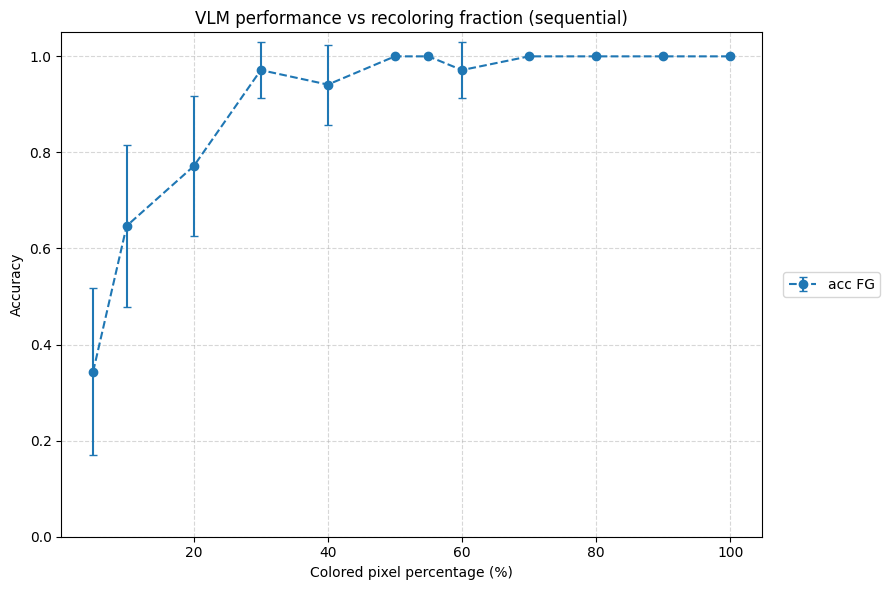

In [106]:
gpt_cf_pred_df = pd.read_csv(GPT / "evaluation_gpt-4o_counterfact.csv")
gpt_cf_pred_df = gpt_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(gpt_cf_pred_df)
plot_vlm_prolific(gpt_cf_pred_df, ci=True)

## 2.4. Shape Dataset (GPT-4o)

In [27]:
suffix = "shapes"
gpt_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    backend="gpt",
    model_name="gpt-4o",
    image_root=DATA,
    device=None,   # ignored for GPT
)

out_path = GPT / f"evaluation_shapes_{model_name}_{suffix}.csv"
gpt_shape_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1331/1331 [19:37<00:00,  1.13it/s]


,object,image_path,correct_answer,pred_color_this,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,hexagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,yellow,yellow,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,pentagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,purple,purple,shape,purple,purple,FG,55,FG 55% (seq),seq
2,square,/mnt/lustre/work/eickhoff/esx061/color-concept...,blue,white,shape,blue,blue,FG,5,FG 5% (seq),seq
3,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,shape,brown,brown,FG,50,FG 50% (seq),seq
4,pentagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,orange,orange,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...
1326,circle,/mnt/lustre/work/eickhoff/esx061/color-concept...,grey,white,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,hexagon,/mnt/lustre/work/eickhoff/esx061/color-concept...,brown,brown,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,white,black,shape,blue,white,FG,0,FG 0% (seq),seq
1329,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,red,white,shape,red,white,BG,40,BG 40% (seq),seq


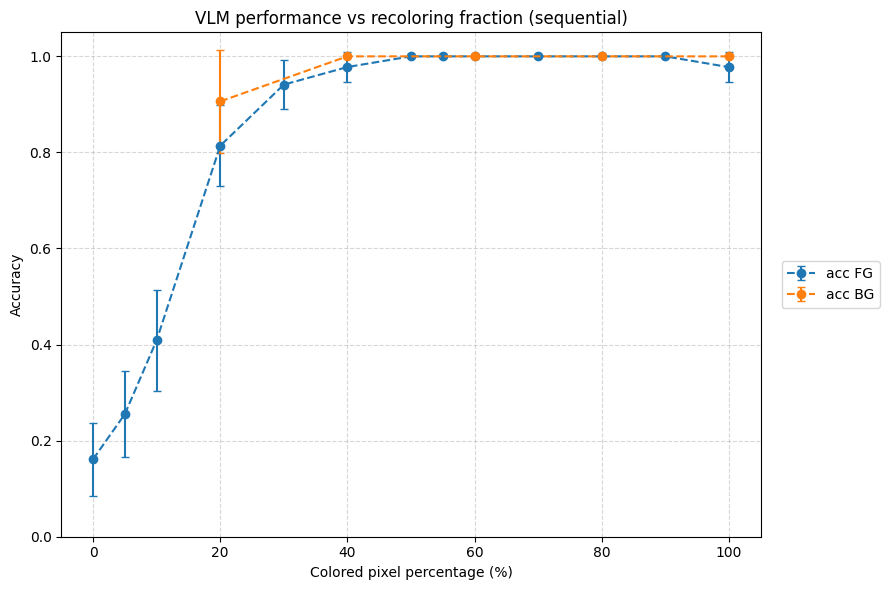

In [107]:
gpt_shape_pred_df = pd.read_csv(GPT / "evaluation_gpt-4o_shapes.csv")
gpt_shape_pred_df = gpt_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(gpt_shape_pred_df)
plot_vlm_prolific(gpt_shape_pred_df, ci=True)

# 3. Qwen3-VL

In [ ]:
model_name = "Qwen3-VL-8B-Instruct"

processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen3-VL-8B-Instruct",
    trust_remote_code=True
)

model = AutoModelForVision2Seq.from_pretrained(
    "Qwen/Qwen3-VL-8B-Instruct",
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    quantization_config=bnb_config,
    trust_remote_code=True,
).to(device)


QWEN = DATA / "Qwen3_results"
QWEN.mkdir(parents=True, exist_ok=True)

preprocessor_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

/mnt/lustre/work/eickhoff/esx061/.conda/envs/thesis/lib/python3.11/site-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

## 3.1. Introspection question (Qwen3-VL)

In [27]:
calibration = ask_vlm_introspection_threshold(
    backend="qwen",
    processor=processor,
    model=model,
    device=device,
    model_name=model_name,
)

threshold = calibration["introspection_threshold"]
print(threshold)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0


## 3.2. Color Prior Dataset (Qwen3-VL)

In [ ]:
suffix = "image_priors"
qwen_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    processor=processor,
    model=model,
    device=device,
    image_root=DATA,
    desc="Evaluating canonical object colors (correct-prior stimuli)",
)

out_path = QWEN / f"evaluation_{model_name}_{suffix}.csv"
qwen_prior_pred_df.to_csv(out_path, index=False)

## 3.3. Counterfact Color Dataset (Qwen3-VL)

In [ ]:
suffix = "counterfact"
qwen_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    processor=processor,
    model=model,
    device=device,
    image_root=DATA,
    desc="Evaluating counterfact object colors (counterfact stimuli)",
)

out_path = QWEN / f"evaluation_{model_name}_{suffix}.csv"
qwen_cf_pred_df.to_csv(out_path, index=False)

## 3.4. Shape Dataset (Qwen3-VL)

In [ ]:
suffix = "shapes"
qwen_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    processor=processor,
    model=model,
    device=device,
    image_root=DATA,
    desc="Evaluating shapes",
)

out_path = QWEN / f"evaluation_{model_name}_{suffix}.csv"
qwen_shape_pred_df.to_csv(out_path, index=False)